<a href="https://colab.research.google.com/github/shinnew9/cse347-cse447RL/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
# epsilon_min = 0.01
# epsilon_decay = 0.995
epsilon_start, epsilon_end, epsilon_decay = 1.0, 0.05, 0.999
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000
target_update_freq = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
q_target = QNetwork(state_dim, n_actions).to(device)
q_target.load_state_dict(q_net.state_dict())  # copy weights
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()

replay_buffer = deque(maxlen=replay_buffer_size)

In [4]:
def epsilon_greedy(state, epsilon):
  # TODO
  """Selects an action using epsilon-greedy policy."""
  if random.random() > epsilon:
    with torch.no_grad():
      state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
      q_values = q_net(state_tensor)
      action = torch.argmax(q_values).item()
  else:
    action = env.action_space.sample()
  return action

In [5]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
      next_q_values = q_target(next_states).max(1)[0].detach()
      targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)
    optimizer.step()

In [6]:
## MAIN Loop ###
epsilon = epsilon_start
# rewards_dqn = []
rewards_history = []
global_step = 0

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:
    global_step += 1
    action = epsilon_greedy(state, epsilon)
    # next_state, reward, done, _, _ = env.step(action)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    replay_buffer.append((state, action, reward, next_state, float(done)))

    state = next_state
    total_reward += reward

    train_dqn()

    if global_step % target_update_freq == 0:
      q_target.load_state_dict(q_net.state_dict())

  rewards_history.append(total_reward)
  epsilon = max(epsilon_end, epsilon * epsilon_decay)

  # Decay epsilon
  # epsilon = max(epsilon_min, epsilon * epsilon_decay)

  if (episode + 1) % 100 == 0:
    avg = np.mean(rewards_history[-100:])
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.2f}")

env.close()

/tmp/ipython-input-360927061.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


Episode 100: Total Reward = -200.00, Epsilon = 0.90
Episode 200: Total Reward = -200.00, Epsilon = 0.82
Episode 300: Total Reward = -200.00, Epsilon = 0.74
Episode 400: Total Reward = -200.00, Epsilon = 0.67
Episode 500: Total Reward = -200.00, Epsilon = 0.61
Episode 600: Total Reward = -200.00, Epsilon = 0.55
Episode 700: Total Reward = -200.00, Epsilon = 0.50
Episode 800: Total Reward = -161.00, Epsilon = 0.45
Episode 900: Total Reward = -165.00, Epsilon = 0.41
Episode 1000: Total Reward = -160.00, Epsilon = 0.37
Episode 1100: Total Reward = -200.00, Epsilon = 0.33
Episode 1200: Total Reward = -154.00, Epsilon = 0.30
Episode 1300: Total Reward = -136.00, Epsilon = 0.27
Episode 1400: Total Reward = -120.00, Epsilon = 0.25
Episode 1500: Total Reward = -177.00, Epsilon = 0.22
Episode 1600: Total Reward = -148.00, Epsilon = 0.20
Episode 1700: Total Reward = -166.00, Epsilon = 0.18
Episode 1800: Total Reward = -155.00, Epsilon = 0.17
Episode 1900: Total Reward = -162.00, Epsilon = 0.15
Ep

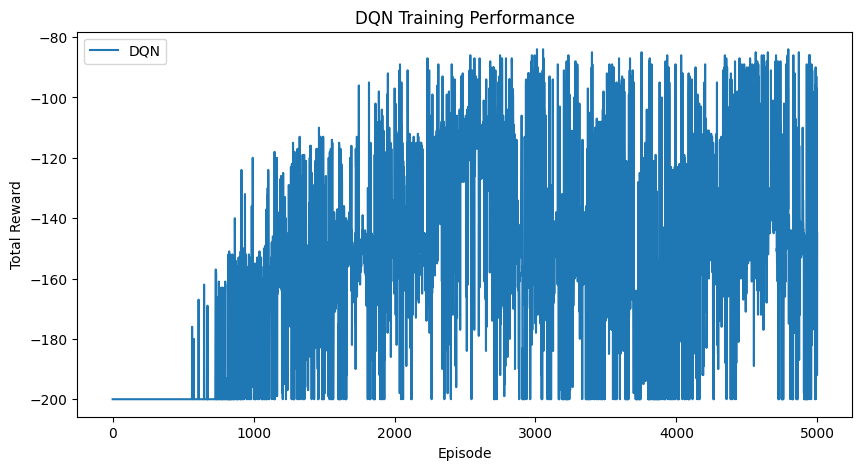

In [7]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(rewards_history, label="DQN")
plt.xlabel("Episode"); plt.ylabel("Total Reward")
plt.title("DQN Training Performance")
plt.legend()
plt.show()

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [7]:
!pip install swig
!pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409499 sha256=ddf74f9e51453a47cba766880999dfb841afc76d1a780d5889bf2300e8ef13f7
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


ep   20 | steps    1802 | return (last20) -140.18 | buf 1802 | eps 0.99
ep   40 | steps    3677 | return (last20) -207.27 | buf 3677 | eps 0.99
ep   60 | steps    5542 | return (last20) -180.90 | buf 5542 | eps 0.98
ep   80 | steps    7364 | return (last20) -191.46 | buf 7364 | eps 0.98
ep  100 | steps    9213 | return (last20) -166.13 | buf 9213 | eps 0.97
[eval @ 10,000 steps] return mean=-191.4 ± 107.4, eps=0.97
ep  120 | steps   10950 | return (last20) -204.74 | buf 10950 | eps 0.97
ep  140 | steps   12958 | return (last20) -133.95 | buf 12958 | eps 0.96
ep  160 | steps   14889 | return (last20) -174.94 | buf 14889 | eps 0.95
ep  180 | steps   16742 | return (last20) -154.81 | buf 16742 | eps 0.95
ep  200 | steps   18595 | return (last20) -130.72 | buf 18595 | eps 0.94
[eval @ 20,000 steps] return mean=-239.1 ± 27.2, eps=0.94
ep  220 | steps   20563 | return (last20) -115.66 | buf 20563 | eps 0.93
ep  240 | steps   22363 | return (last20) -115.67 | buf 22363 | eps 0.93
ep  260 | st

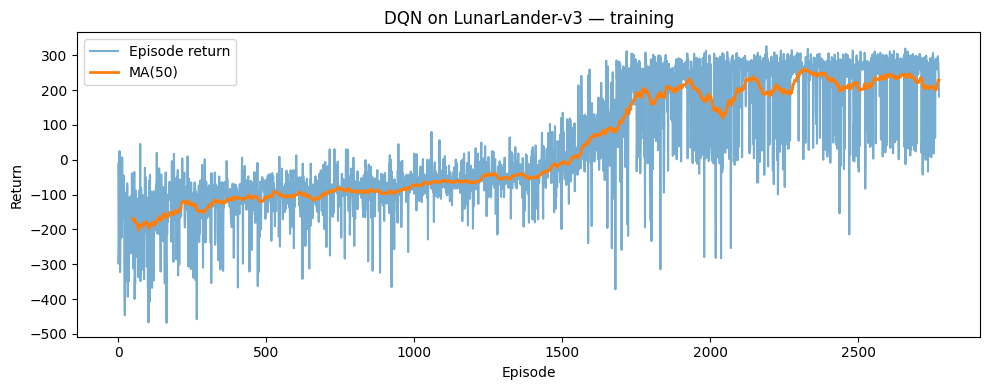

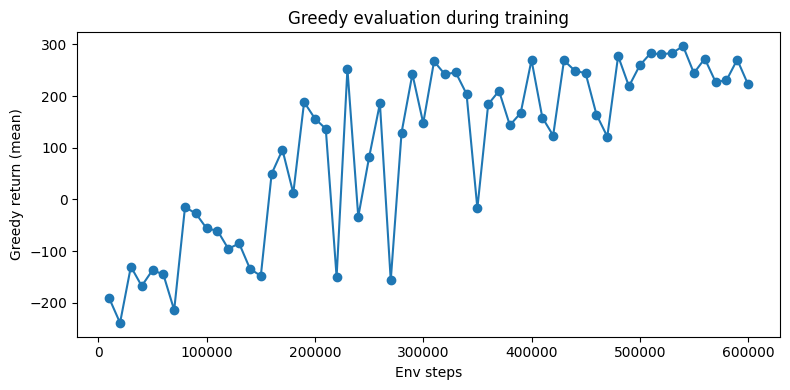


Final greedy eval over 10 eps: mean=258.9 ± 34.7


In [9]:
# DQN for LunarLander (Gymnasium) — PyTorch
# If you're on classic gym (not gymnasium): use env_id = "LunarLander-v2"
# and change reset/step unpacking as noted below.

import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim


# env
try:
    import gymnasium as gym
    env_id = "LunarLander-v3"  # Gymnasium
except ImportError:
    import gym
    env_id = "LunarLander-v2"  # Classic gym


# Hyperparameters (good starters)
SEED = 42
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
BUFFER_SIZE = 200_000
WARMUP_STEPS = 10_000         # collect this many steps before learning
TOTAL_STEPS = 600_000         # or use episodes; steps is easier to schedule eps
TARGET_UPDATE_FREQ = 1000     # hard update every N gradient steps
EPS_START, EPS_END = 1.0, 0.05
EPS_DECAY_STEPS = 300_000     # linear decay over these many env steps
GRAD_CLIP = 10.0

EVAL_EVERY = 10_000           # evaluate greedy every N steps
EVAL_EPISODES = 5


# Utilities
def set_seed_everywhere(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

class ReplayBuffer:
    def __init__(self, capacity, state_dim):
        self.capacity = capacity
        self.buf = deque(maxlen=capacity)
        self.state_dim = state_dim

    def __len__(self): return len(self.buf)

    def push(self, s, a, r, ns, done):
        self.buf.append((s, a, r, ns, done))

    def sample(self, batch_size, device):
        batch = random.sample(self.buf, batch_size)
        s, a, r, ns, d = zip(*batch)
        s  = torch.as_tensor(np.array(s),  dtype=torch.float32, device=device)
        a  = torch.as_tensor(a,           dtype=torch.int64,   device=device)
        r  = torch.as_tensor(r,           dtype=torch.float32, device=device)
        ns = torch.as_tensor(np.array(ns),dtype=torch.float32, device=device)
        d  = torch.as_tensor(d,           dtype=torch.float32, device=device)
        return s, a, r, ns, d


# Networks
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128),       nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    def forward(self, x): return self.net(x)


# ε schedule
class LinearEpsilon:
    def __init__(self, eps_start, eps_end, decay_steps):
        self.s, self.e, self.n = eps_start, eps_end, decay_steps
    def value(self, t):
        if t >= self.n: return self.e
        return self.e + (self.s - self.e) * (1 - t/self.n)


# Action selection
def select_action(q_net, state, epsilon, n_actions, device):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    with torch.no_grad():
        s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q = q_net(s)                      # (1, nA)
        return int(torch.argmax(q, dim=1).item())


# Train step
def dqn_train_step(q_net, q_tgt, buffer, optimizer, device):
    s, a, r, ns, d = buffer.sample(BATCH_SIZE, device)
    # Q(s,a)
    q_sa = q_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
    # target: r + gamma * max_a' Q_tgt(ns, a') * (1-done)
    with torch.no_grad():
        q_next = q_tgt(ns).max(dim=1)[0]
        target = r + GAMMA * q_next * (1.0 - d)
    loss = nn.MSELoss()(q_sa, target)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP)
    optimizer.step()
    return float(loss.item())


# Evaluation (greedy)
def evaluate(env, q_net, device, episodes=EVAL_EPISODES, render=False):
    rets = []
    for _ in range(episodes):
        out = env.reset(seed=random.randint(0, 10_000))
        s = out[0] if isinstance(out, tuple) else out
        done = False; ep_ret = 0.0
        while not done:
            a = select_action(q_net, s, epsilon=0.0, n_actions=env.action_space.n, device=device)
            step = env.step(a)
            if len(step) == 5: ns, r, terminated, truncated, _ = step
            else:              ns, r, done, _ = step; terminated, truncated = done, False
            done = terminated or truncated
            ep_ret += float(r)
            s = ns
            if render: env.render()
        rets.append(ep_ret)
    return np.mean(rets), np.std(rets)


# Main training loop (by steps)
def train_dqn_lunarlander():
    set_seed_everywhere(SEED)
    env = gym.make(env_id)
    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    q_net  = QNetwork(state_dim, n_actions).to(device)
    q_tgt  = QNetwork(state_dim, n_actions).to(device)
    q_tgt.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=LR)

    buffer = ReplayBuffer(BUFFER_SIZE, state_dim)
    eps_sched = LinearEpsilon(EPS_START, EPS_END, EPS_DECAY_STEPS)

    returns, losses, eval_points, eval_means = [], [], [], []
    step_count = 0
    episode = 0

    while step_count < TOTAL_STEPS:
        # reset
        out = env.reset(seed=random.randint(0, 10_000))
        s = out[0] if isinstance(out, tuple) else out
        done = False
        ep_ret = 0.0

        while not done and step_count < TOTAL_STEPS:
            epsilon = eps_sched.value(step_count)
            a = select_action(q_net, s, epsilon, n_actions, device)
            step = env.step(a)
            if len(step) == 5:
                ns, r, terminated, truncated, _ = step
                done = terminated or truncated
            else:
                ns, r, done, _ = step
            buffer.push(s, a, float(r), ns, float(done))
            s = ns
            ep_ret += float(r)
            step_count += 1

            # learn
            if step_count > WARMUP_STEPS and len(buffer) >= BATCH_SIZE:
                loss = dqn_train_step(q_net, q_tgt, buffer, optimizer, device)
                losses.append(loss)
                # hard target update
                if len(losses) % TARGET_UPDATE_FREQ == 0:
                    q_tgt.load_state_dict(q_net.state_dict())

            # periodic evaluation (greedy)
            if step_count % EVAL_EVERY == 0 and step_count >= WARMUP_STEPS:
                eval_mean, eval_std = evaluate(env, q_net, device, episodes=EVAL_EPISODES)
                eval_points.append(step_count)
                eval_means.append(eval_mean)
                print(f"[eval @ {step_count:,} steps] return mean={eval_mean:.1f} ± {eval_std:.1f}, eps={epsilon:.2f}")

        returns.append(ep_ret)
        episode += 1
        if episode % 20 == 0:
            avg_last = np.mean(returns[-20:])
            print(f"ep {episode:4d} | steps {step_count:7d} | return (last20) {avg_last:7.2f} | buf {len(buffer)} | eps {epsilon:.2f}")

    env.close()

    # Plots
    # 1) training returns per episode
    plt.figure(figsize=(10,4))
    plt.plot(returns, alpha=0.6, label="Episode return")
    # moving average for readability
    if len(returns) > 50:
        ma = np.convolve(returns, np.ones(50)/50, mode='valid')
        plt.plot(range(49, 49+len(ma)), ma, lw=2, label="MA(50)")
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title(f"DQN on {env_id} — training")
    plt.legend(); plt.tight_layout(); plt.show()

    # 2) eval curve vs steps
    if len(eval_points) > 0:
        plt.figure(figsize=(8,4))
        plt.plot(eval_points, eval_means, marker="o")
        plt.xlabel("Env steps"); plt.ylabel("Greedy return (mean)")
        plt.title("Greedy evaluation during training")
        plt.tight_layout(); plt.show()

    # final evaluation (greedy)
    final_mean, final_std = evaluate(gym.make(env_id), q_net, device, episodes=10)
    print(f"\nFinal greedy eval over 10 eps: mean={final_mean:.1f} ± {final_std:.1f}")

    return q_net, returns, (eval_points, eval_means)

if __name__ == "__main__":
    train_dqn_lunarlander()
